# (1) Train predicator (classifier) for AFA 
The AFA problem contains the training of a classifier that is able to predict well based on any acquired subset of features. 
In this notebook we train and save such a classifier 

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define paths

Paths for data

In [11]:
from afa.configurations.utils_ts import specify_default_paths_ts
# which dataset to work on 
dataset_name   = "miiv_test"

# name for of missingness scenario 
miss_scenario  = 'MCAR_1_from_miiv'

# data root directory
data_root = '/home2/joshua.wendland/Documents/afa_mi_policies/data/'

# automatically specify some path locations (change paths manually if needed) 
paths = specify_default_paths_ts(dataset_name = dataset_name , miss_scenario = miss_scenario, data_root=data_root)

Paths for model

In [3]:
# name for predictor 
predictor_model_name  = 'TCN'

# new (where to save the model) 
predictor_model_dir = paths['data_dir'] + 'predictor_models' + '/' + predictor_model_name + '/'

## Load dataset with missingness 
At first, we want to load the dataset 

Includes loading: 
- superfeature mapping
- problem
- afa_problem 
- missingness_model

In [8]:
from afa.data_modelling.datasets.data_loader.data_loader_ts import DataLoader_ts

In [12]:
data_loader = DataLoader_ts(     data_file                  = paths['data_file'],
                                 temporal_data_file         = paths['temporal_data_file'],
                                 superfeature_mapping_file  = paths['superfeature_mapping_file'],
                                 problem_file               = paths['problem_file'],
                                 afa_problem_files          = paths['afa_problem_files'], 
                                 miss_model_files           = paths['miss_model_files'], 
                                 folds_file                 = paths['folds_file'] )
dataset = data_loader.load() 

Padding sequences: 100%|██████████| 100/100 [00:00<00:00, 1869.65it/s]


## Create afa dataset with missingness 
To train an AFA predictor, we need to induce artificial missingness (such that the predictor is robust to the missingness pattern). 
Here, we use a simple model to create missingness randomly (MCAR).

In [13]:
from afa.afa_datasets.utils_ts import create_MCAR_afa_dataset_ts

In [33]:
afa_dataset = create_MCAR_afa_dataset_ts( dataset, MCAR_ratio = 0.9, n_samples = 5)

Change base_model to stationary_constant
Change base_model to stationary_constant
Change base_model to stationary_constant
Change base_model to stationary_constant
Change base_model to stationary_constant
Change base_model to stationary_constant
Set weight for constant stationary model ...
Set weight for constant stationary model ...
Set weight for constant stationary model ...
Set weight for constant stationary model ...
Set weight for constant stationary model ...
Set weight for constant stationary model ...


## Train Predictor 

### Initialize predictor 

In [17]:
from afa.afa_models.afa_predictors.afa_predictor_ts import AFAPredictor_ts

In [34]:
predictor_model_params = {
    'name' : predictor_model_name, 
    'directory': predictor_model_dir,
    'base_model_params' : {   'model_type': 'impute_then_regress',
                              'imputer_params' : 
                                       {   
                                      'model_type': 'simple_imputer',
                                      'mode' : 'imputation'
                                      },
                              'predictor_params' : 
                                       {   
                                      'model_type': 'ann',
                                      'mode' : 'classification',
                                      'units':              1,
                                      'layers': 1,
                                      'learning_rate': 0.01,
                                      'batch_size' :128,
                                      'epochs': 100 
                                      }
                          }
    }

# predictor_model_params = {
#     'name' : predictor_model_name, 
#     'directory': predictor_model_dir,
#     'base_model_params' : {   
#         'model_type': 'TCN',  
#         'seed': 54,                     # seed for reproduceability
#         'lr': 0.01,                     # initial learning rate for lr-scheduler
#         'time excluded': True,          # for logging purposes, if time is included as a feature
#         'num_inputs': 48,                # The number of features that are used as input
#         'num_layers': 2,                # The number of temporal conv. layers
#         'channels_per_layer': 8,        # The number of channels per temp. conv. layer
#         'kernel_size': 3,               # Num time steps for kernel window
#         'max_epochs': 20,              # Max. epochs for training
#         'batch_size': 2000,             # Number of samples per batch
#         'dropout': 0.3,                 # Dropout for all temp. conv. layers
#         'patience': 60,                 # Num epochs as patience for early stopping, default 50.
#         'weight_decay': 0,              # Weight decay for L2 regularization of Adam optmizer
#         'wandb_logger': False,           # If weights and biases logger should be used
#         #'wandb_project_name': 'Synthetic_2 classifier (AFA)'    # project name if wandb_logger is used
#     }
# }

In [35]:
afa_predictor = AFAPredictor_ts(    name            = predictor_model_params['name'], 
                                    model_params    = predictor_model_params, 
                                    directory       = predictor_model_params['directory'])   

Loading already trained weights for SimpleImputer...
Loading already trained weights for ann...


In [27]:
print('Does any of the layers have any NAN values for weights?')
for i,p in enumerate(afa_predictor.base_model.model.parameters()):
    print(i, p.isnan().any())
print('fhgsdf')

Does any of the layers have any NAN values for weights?
0 tensor(False)
1 tensor(False)
2 tensor(False)
3 tensor(False)
4 tensor(False)
5 tensor(False)
6 tensor(False)
7 tensor(False)
8 tensor(False)
9 tensor(False)
10 tensor(False)
11 tensor(False)
12 tensor(False)
13 tensor(False)
14 tensor(False)
15 tensor(False)
fhgsdf


Convert superR to R: 100%|██████████| 6/6 [00:00<00:00, 10292.77it/s]

Fit simple_imputer model
Finished fitting simple_imputer model
Fit ann model
Epoch 1/100


34/34 [==============================] - 0s 3ms/step - loss: nan - binary_accuracy: 0.4215 - val_loss: nan - val_binary_accuracy: 0.5354
Epoch 2/100
34/34 [==============================] - 0s 1ms/step - loss: nan - binary_accuracy: 0.4215 - val_loss: nan - val_binary_accuracy: 0.5354
Epoch 3/100
34/34 [==============================] - 0s 1ms/step - loss: nan - binary_accuracy: 0.4215 - val_loss: nan - val_binary_accuracy: 0.5354
Epoch 4/100
34/34 [==============================] - 0s 931us/step - loss: nan - binary_accuracy: 0.4215 - val_loss: nan - val_binary_accuracy: 0.5354
Epoch 5/100
34/34 [==============================] - 0s 961us/step - loss: nan - binary_accuracy: 0.4215 - val_loss: nan - val_binary_accuracy: 0.5354
Epoch 6/100
34/34 [==============================] - 0s 981us/step - loss: nan - binary_accuracy: 0.4215 - val_loss: nan - val_binary_accuracy: 0.5354
Epoch 7/100
34/34 [==============================] - 0s 929us/step - loss: nan - binary_accuracy: 0.4215 - val_l

Convert superR to R: 100%|██████████| 6/6 [00:00<00:00, 8997.43it/s]

150/150 [==============================] - 0s 343us/step
Model accuracy: 99.3%
Model accuracy: 99.3%
Error while plotting ROC curve.
 Input contains NaN.


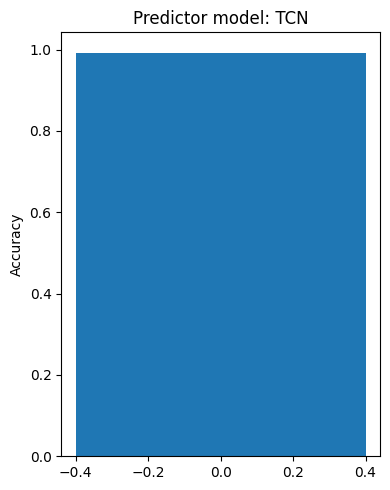

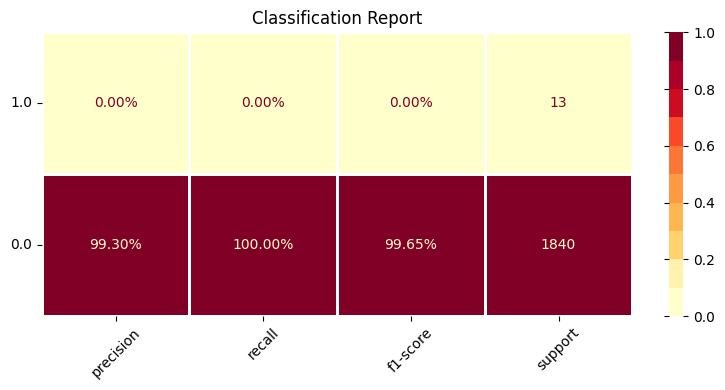

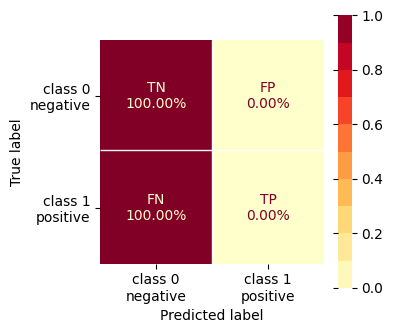

In [36]:
afa_predictor.fit(afa_dataset, 
                  fold = 0, 
                  train_split = 'train', 
                  valid_split = 'val', 
                  fit_again = True)

In [37]:
label_pred = afa_predictor.predict( afa_dataset, fold = 0, split = 'val', n_samples = 1 )

Convert superR to R: 100%|██████████| 6/6 [00:00<00:00, 6253.93it/s]

 38/150 [======>.......................] - ETA: 0s

150/150 [==============================] - 0s 1ms/step


### Write report

In [38]:
explanation_file = afa_predictor.directory + 'model_report.md'  # +  'reports/' + 'model_report' 
afa_predictor.explain(file= explanation_file, format = 'markdown')

AttributeError: 'NoneType' object has no attribute 'savefig'